In [274]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Загрузка данных
train_df = pd.read_excel(r'C:\Users\Mrsoning\OneDrive\Документы\GitHub\Intensive_3/train.xlsx', parse_dates=['dt'])
test_df = pd.read_excel(r'C:\Users\Mrsoning\OneDrive\Документы\GitHub\Intensive_3/test.xlsx', parse_dates=['dt'])

train_df

,dt,Цена на арматуру
0,2015-01-05,32900
1,2015-01-12,32500
2,2015-01-19,32000
3,2015-01-26,30700
4,2015-02-02,30300
...,...,...
395,2022-08-01,47500
396,2022-08-08,49000
397,2022-08-15,47500
398,2022-08-22,46500


In [275]:
train_df.info

<bound method DataFrame.info of             dt  Цена на арматуру
0   2015-01-05             32900
1   2015-01-12             32500
2   2015-01-19             32000
3   2015-01-26             30700
4   2015-02-02             30300
..         ...               ...
395 2022-08-01             47500
396 2022-08-08             49000
397 2022-08-15             47500
398 2022-08-22             46500
399 2022-08-29             46000

[400 rows x 2 columns]>

In [276]:
train_df.describe()

,dt,Цена на арматуру
count,400,400.000000
mean,2018-11-01 12:00:00,39229.475000
min,2015-01-05 00:00:00,21000.000000
25%,2016-12-03 06:00:00,31075.000000
50%,2018-11-01 12:00:00,35450.000000
75%,2020-09-29 18:00:00,42000.000000
max,2022-08-29 00:00:00,79000.000000
std,NaN,13407.979668


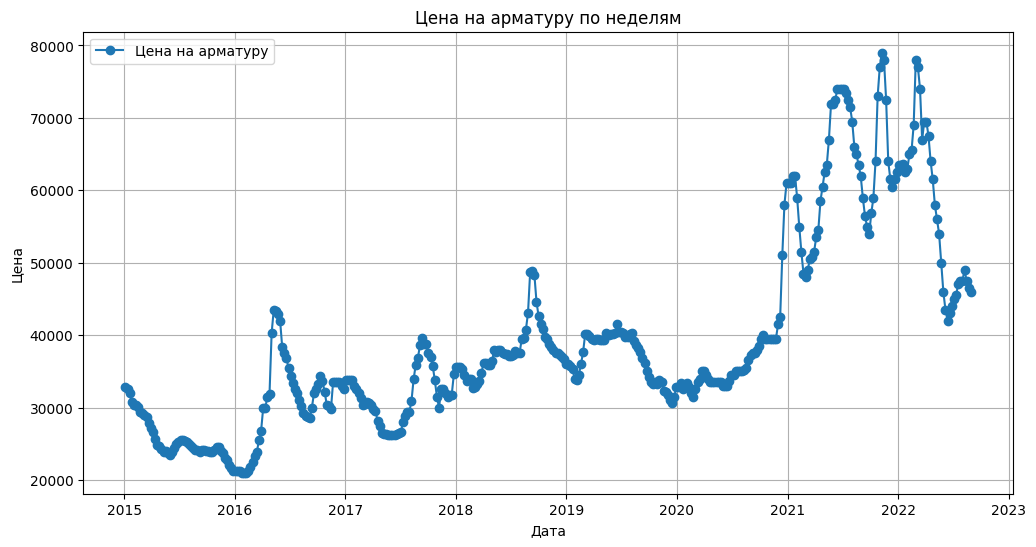

In [277]:
# Визуализация цен на арматуру
plt.figure(figsize=(12, 6))
plt.plot(train_df['dt'], train_df['Цена на арматуру'], label='Цена на арматуру', marker='o')
plt.title('Цена на арматуру по неделям')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.grid()
plt.show()


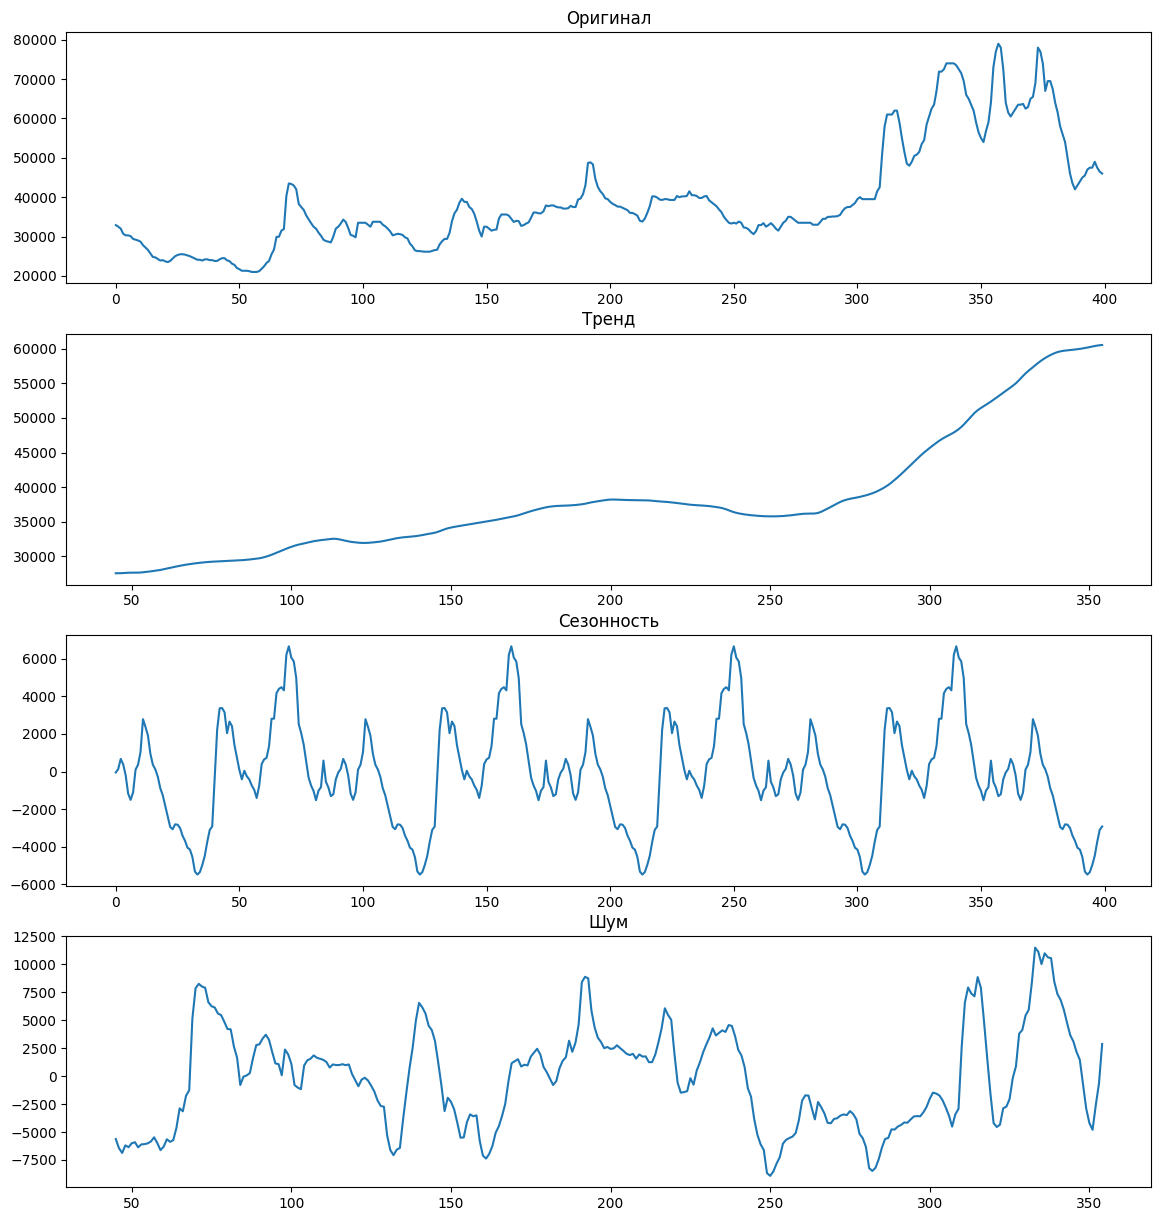

In [278]:
# Разложим ряд на компоненты и ответим: Есть ли у данного ряда тренд? Есть ли у данного ряда сезонность?
from statsmodels.tsa.seasonal import seasonal_decompose
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(14, 15))
decompose = seasonal_decompose(train_df[['Цена на арматуру']], period=90)

ax[0].set_title('Оригинал')
ax[1].set_title('Тренд')
ax[2].set_title('Сезонность')
ax[3].set_title('Шум')

decompose.observed.plot(ax=ax[0])
decompose.trend.plot(ax=ax[1])
decompose.seasonal.plot(ax=ax[2])
decompose.resid.plot(ax=ax[3]);

In [279]:
from statsmodels.tsa.stattools import adfuller

# Функция для проверки стационарности
def check_stationarity(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])
    if result[1] <= 0.05:
        print("Ряд стационарен")
    else:
        print("Ряд нестационарен")

# Проверка исходного ряда на стационарность
check_stationarity(train_df['Цена на арматуру'])

ADF Statistic: -1.9258699893713453
p-value: 0.3199906102569917
Critical Values: {'1%': -3.4470566389664703, '5%': -2.8689037160476016, '10%': -2.570692663557422}
Ряд нестационарен


In [280]:
# Приведение ряда к стационарному с помощью дифференцирования
train_df['Цена на арматуру_diff'] = train_df['Цена на арматуру'].diff().dropna()

# Проверка стационарности после дифференцирования
check_stationarity(train_df['Цена на арматуру_diff'].dropna())

ADF Statistic: -7.7060615041152065
p-value: 1.3006938373810178e-11
Critical Values: {'1%': -3.447405233596701, '5%': -2.8690569369014605, '10%': -2.5707743450830893}
Ряд стационарен


In [281]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Создание признаков на основе даты
train_df['year'] = train_df['dt'].dt.year
train_df['month'] = train_df['dt'].dt.month
train_df['day_of_week'] = train_df['dt'].dt.dayofweek

test_df['year'] = test_df['dt'].dt.year
test_df['month'] = test_df['dt'].dt.month
test_df['day_of_week'] = test_df['dt'].dt.dayofweek

# Разделение данных на признаки и целевую переменную
X_train = train_df.drop(['dt', 'Цена на арматуру'], axis=1)
y_train = train_df['Цена на арматуру']
X_test = test_df.drop(['dt', 'Цена на арматуру'], axis=1)
y_test = test_df['Цена на арматуру']


# Преобразование данных в pandas Series с временным индексом
y_train = pd.Series(y_train.values, index=train_df['dt'])
y_test = pd.Series(y_test.values, index=test_df['dt'])

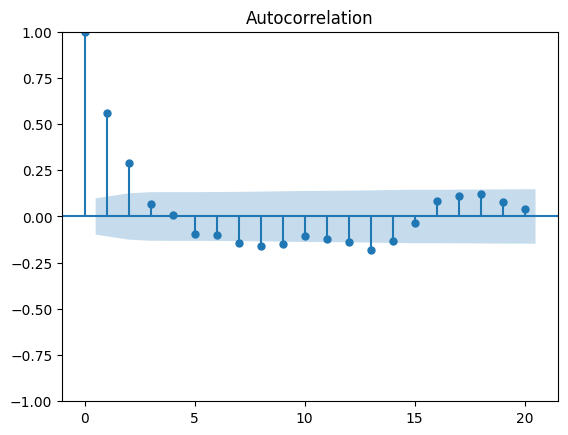

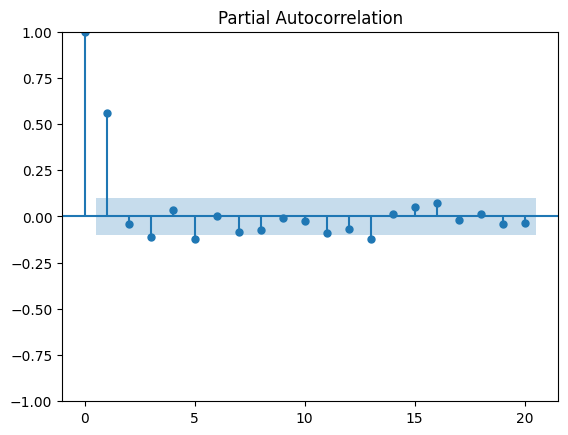

c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible start

Предсказанные значения:
Series([], Name: predicted_mean, dtype: float64)
Индексы предсказанных значений:
Index([], dtype='int64')


c:\Python\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


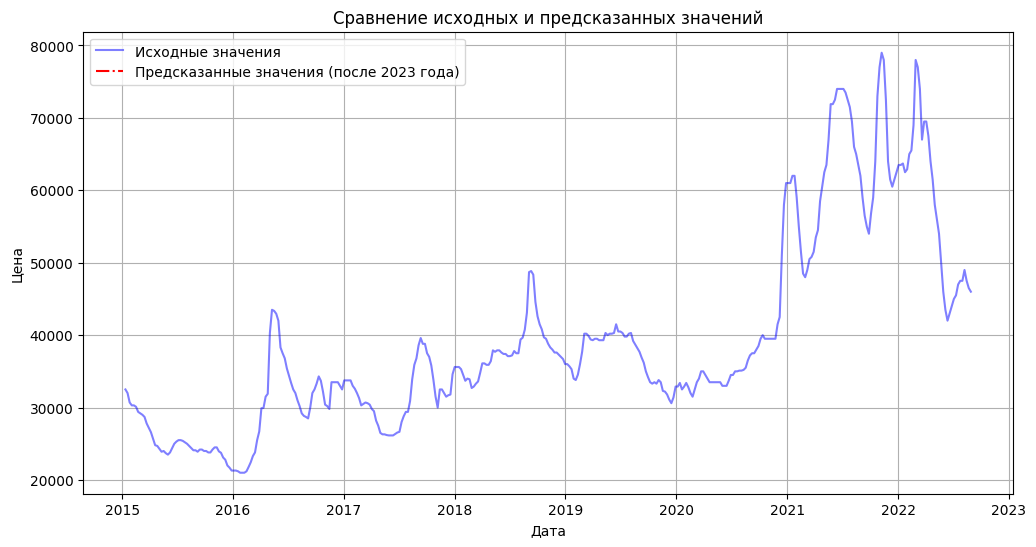

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf #For ACF and PACF plots

# Приведение ряда к стационарному с помощью дифференцирования
train_df['Цена на арматуру_diff'] = train_df['Цена на арматуру'].diff()

# Удаление строк с пропущенными значениями
train_df = train_df.dropna()

# Анализ ACF и PACF (для выбора p и q)
plot_acf(train_df['Цена на арматуру_diff'], lags=20)
plt.show()
plot_pacf(train_df['Цена на арматуру_diff'], lags=20)
plt.show()

# Исправлено: Теперь y_train содержит исходные значения, а не разности
X_train = train_df.drop(['dt', 'Цена на арматуру', 'Цена на арматуру_diff'], axis=1)
y_train = train_df['Цена на арматуру']

# Создание данных для прогнозирования (после 2023 года)
future_data = train_df[train_df['dt'] >= '2023-01-01'].copy()

# Обучение модели ARIMA
try:
    model = ARIMA(y_train, order=(5, 1, 5)) # Предполагается, что ряд уже стационарен
    model_fit = model.fit()

    # Прогнозирование на будущие данные (после 2023 года)
    start_index = len(y_train)
    end_index = len(train_df) + len(y_test) - 1
    y_pred = model_fit.predict(start=start_index, end=end_index)

    # Убедитесь, что y_pred - Series с индексом из дат
    y_pred = pd.Series(y_pred, index=train_df.index[start_index:])

    # Проверка значений
    print("Предсказанные значения:")
    print(y_pred)
    print("Индексы предсказанных значений:")
    print(y_pred.index)

except Exception as e:
    print(f"Ошибка при обучении/прогнозировании ARIMA: {e}")
    y_pred = pd.Series(np.zeros(len(future_data)), index=future_data.index)


# Если данных после 2023 года нет, создаем их искусственно
if len(future_data) == 0:
    last_date = train_df['dt'].iloc[-1]
    future_dates = pd.date_range(start=last_date, periods=365, freq='D') # Прогнозируем на год вперед
    future_data = pd.DataFrame({'dt': future_dates})
    future_data['year'] = future_data['dt'].dt.year
    future_data['month'] = future_data['dt'].dt.month
    future_data['day'] = future_data['dt'].dt.day
    future_data['day_of_week'] = future_data['dt'].dt.dayofweek

    # Создаем X_future на основе новых данных
    X_future = future_data.drop(['dt'], axis=1)  # Убираем столбец с датами

# Для предсказанных значений (убрать, если не дифференцируем)
y_future_pred_original = np.cumsum(y_pred) + train_df['Цена на арматуру'].iloc[-1] #Изменено

# Визуализация результатов
plt.figure(figsize=(12, 6))

# Исходные значения (до 2023 года)
plt.plot(train_df['dt'], train_df['Цена на арматуру'], label='Исходные значения', color='blue', alpha=0.5)

# Предсказанные значения (после 2023 года)
#plot(train_df.index[start_index:], y_future_pred_original, label='Предсказанные значения (после 2023 года)', color='red', linestyle='-.') #Исправлено
plt.plot(y_pred.index, y_future_pred_original, label='Предсказанные значения (после 2023 года)', color='red', linestyle='-.')
plt.title('Сравнение исходных и предсказанных значений')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.grid(True)
plt.show()